# Part 1

## 1a Forward Euler solver

In [11]:
%load_ext autoreload
%autoreload 2
import util
import scipy as sp
import numpy as np


def solve_forward_euler(F, G, u_signal, x0, fs):
    """
    Simulates a state-space system using Forward Euler.
    
    Parameters:
    F, G: System matrices
    u_signal: Array of inputs over time
    x0: Initial state vector
    fs: Sampling frequency
    """
    Ts = 1 / fs
    num_steps = len(u_signal)
    
    # 1. Initialize History Arrays
    # We need to store the state at every time step to plot it later.
    # Shape: (Number of Time Steps, Number of States)
    num_states = len(x0)
    x_history = np.zeros((num_steps, num_states))
    
    # Set current state to initial state
    x_curr = x0.copy()
    
    print(f"Simulating {num_steps} steps with Ts={Ts:.10f}s...")

    # 2. The Simulation Loop
    for n in range(num_steps):
        # Store current state
        x_history[n] = x_curr
        
        # Get current input (handle scalar or vector inputs)
        u_curr = u_signal[n]
        
        # --- THE FORMULA FROM YOUR IMAGE ---
        # Calculate the derivative (slope)
        # dx/dt = F*x + G*u
        dx = (F @ x_curr) + (G * u_curr)
        
        # Euler Step: New = Old + (Slope * StepSize)
        x_next = x_curr + (dx * Ts)
        # -----------------------------------
        
        # Update for next iteration
        x_curr = x_next
        
    return x_history




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1bcd Running forward Euler with linear params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 7023.90
Simulating 35119 steps with Ts=0.0000284746s...
Detected Fundamental: 35.12 Hz
Total harmonic distortion: 0.003017107126654128
Simulating 35119 steps with Ts=0.0000284746s...
freq_res: 7.0238
carrier: 702.38 Hz, modulator: 35.119 Hz)
n=-1: peak at 667.3 Hz with amplitude 0.0035
carrer at n=0: peak at 702.4Hz with amplitude 0.0035
n=1: peak at 737.5 Hz with amplitude 0.0035
TIMD: 81.64965809279697
Simulating 35119 steps with Ts=0.0000284746s...


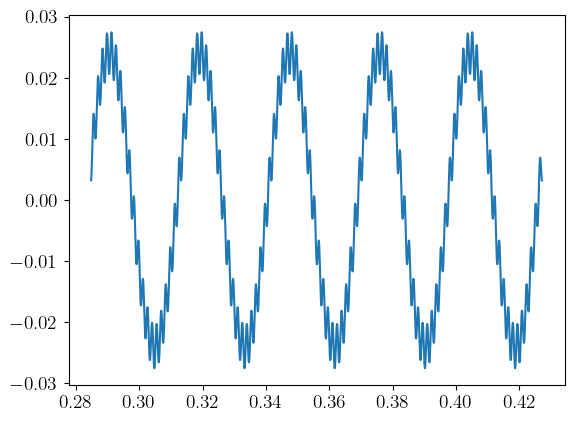

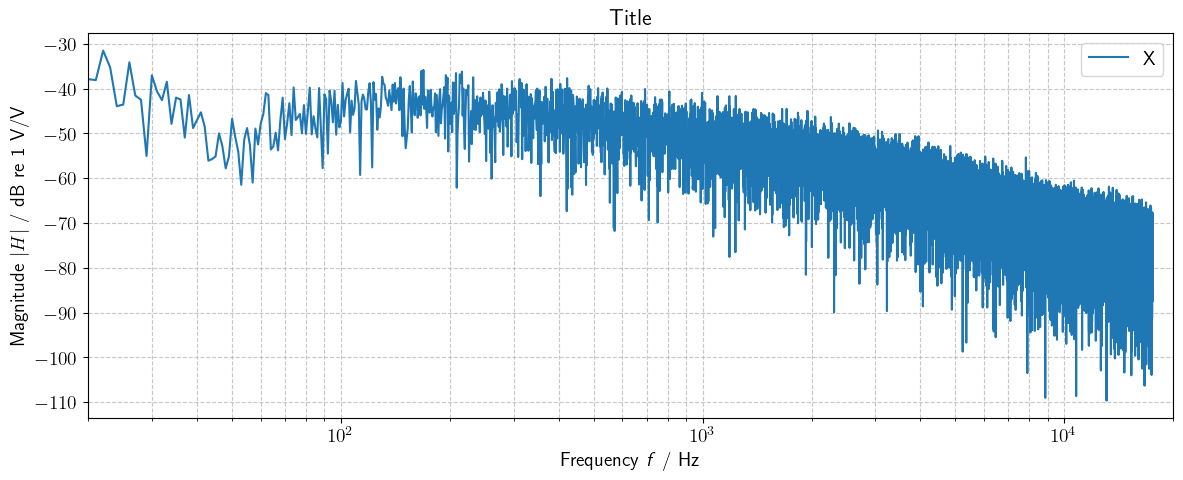

In [12]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt

## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])
x0 = np.array([0,0,0])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)

pink_noise_20Hz = util.generate_pink_noise(fs*1, fs, fmin=20)

duration = 1
freq = fs/1000
T = 1/freq
Vrms = 0.15

t = np.linspace(0,duration,int(duration*fs))
single_freq = np.sqrt(2)*Vrms*np.sin(2 * np.pi * freq * t)

x = solve_forward_euler(F, G, single_freq, x0, fs)

d_single = x[:,2]

# Snip t and d to avoid transient parts
t_snipped = t[int(10*fs*T):int(15*fs*T)]
d_single = d_single[int(10*fs*T):int(15*fs*T)]

thd_val, data = util.thd_r(d_single, fs)
print(f"Total harmonic distortion: {thd_val * 100}")

# plt.figure()
# plt.plot(t_snipped, d_single)

two_freq = np.sqrt(2)*Vrms*np.sin(2 * np.pi * freq * t) + np.sqrt(2)*Vrms*np.sin(2 * np.pi * 20*freq * t) 

x = solve_forward_euler(F, G, two_freq, x0, fs)

d_two_freq = x[:,2]

d_two_freq = d_two_freq[int(10*fs*T):int(15*fs*T)]

timd = util.timd(d_two_freq, fs, freq, 20*freq)
print(f"TIMD: {timd * 100}")

# util.save_wav("signals/two_freq.wav", two_freq, fs)

plt.figure()
plt.plot(t_snipped, d_two_freq)

x = solve_forward_euler(F, G, pink_noise_20Hz, x0, fs)

f, X, X_dB = util.make_spectrum(x[:,0], fs, scaling=True, oneside=True)

util.plot_mag([f], [X], legends=["X"], title="Title")




## 1e Midpoint forward euler

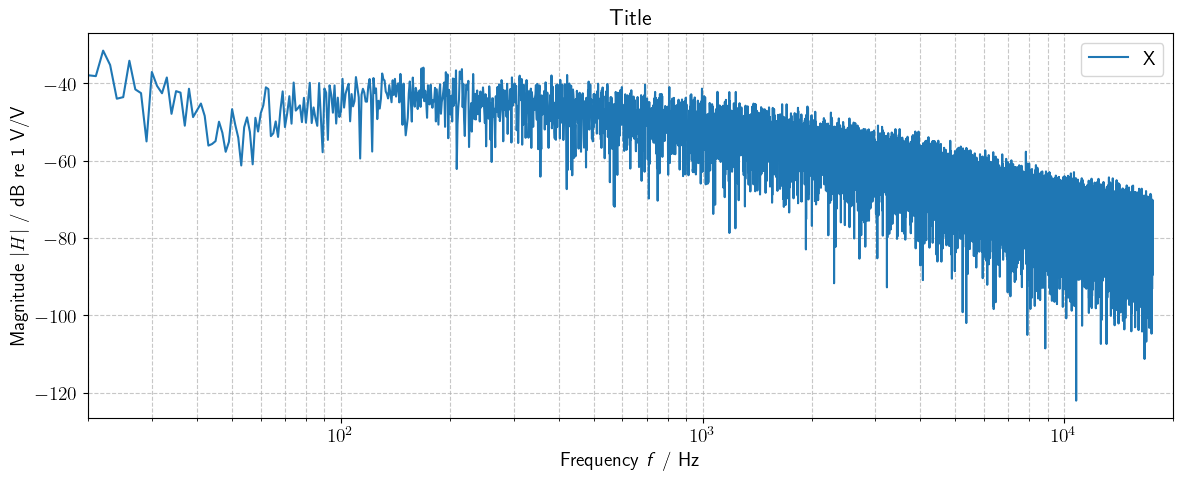

In [17]:
def midpoint_forward_euler(F, G, u_signal, x0, fs):
    Ts = 1 / fs
    num_steps = len(u_signal)
    
    # 1. Initialize History Arrays
    # We need to store the state at every time step to plot it later.
    # Shape: (Number of Time Steps, Number of States)
    num_states = len(x0)
    x_history = np.zeros((num_steps, num_states))
    
    # Set current state to initial state
    x_curr = x0.copy()

    for n in range(num_steps):
        x_history[n] = x_curr
        u_curr = u_signal[n]

        # Calculate slope at start point to find midpoint
        dx1 = (F @ x_curr) + (G * u_curr)
        x_mid = x_curr + 0.5 * Ts * dx1

        # Signal at midpoint
        # Right now it uses signal at starting point. Not the best solution u_mid = 0.5 * (u_signal[n] + u_signal[n+1]) solution imporves accuracy but i get out of bounds for the last sample...
        
        # u_mid = 0.5 * (u_signal[n] + u_signal[n+1])
        u_mid = u_curr
        
        # Slope at midpoint
        dx2 = (F @ x_mid) + (G * u_mid)

        x_next = x_curr + Ts * dx2

        x_curr = x_next

    return x_history

x = midpoint_forward_euler(F, G, pink_noise_20Hz, x0, fs)

f, X, X_dB = util.make_spectrum(x[:,0], fs, scaling=True, oneside=True)

util.plot_mag([f], [X], legends=["X"], title="Title")


## Determine suitable $f_s$

In [ ]:
%load_ext autoreload
%autoreload 2

# klippel values (data/params.txt)
Bl=6.835564595969286
R_e=4.7800112854066175
R_m=2.499311244682717
K_m=1071.063439485575
L_e=0.0003256807665922887
M_m=0.019658990712765827

  
# example values from slides
R_e, L_e, Bl, M_m, R_m, K_m = 5, 0.0006, 7, 18e-3, 2, 1/0.0007


F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

recommended_fs = util.calculate_min_fs(F)
print(recommended_fs)

util.check_stability(F, recommended_fs) 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3869.6821589946794
checking fs=3869.7 Hz => max eigenvalue magnitude: 1.0000


False

In [ ]:

# X = F + u*G
# state vector
# X = np.array([
#     i_n,
#     d_n,
#     v_n
# ])

# system matrix
F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

# input matrix
G = np.array([
    [1.0/L_e],
    [0.0],
    [0.0]
])


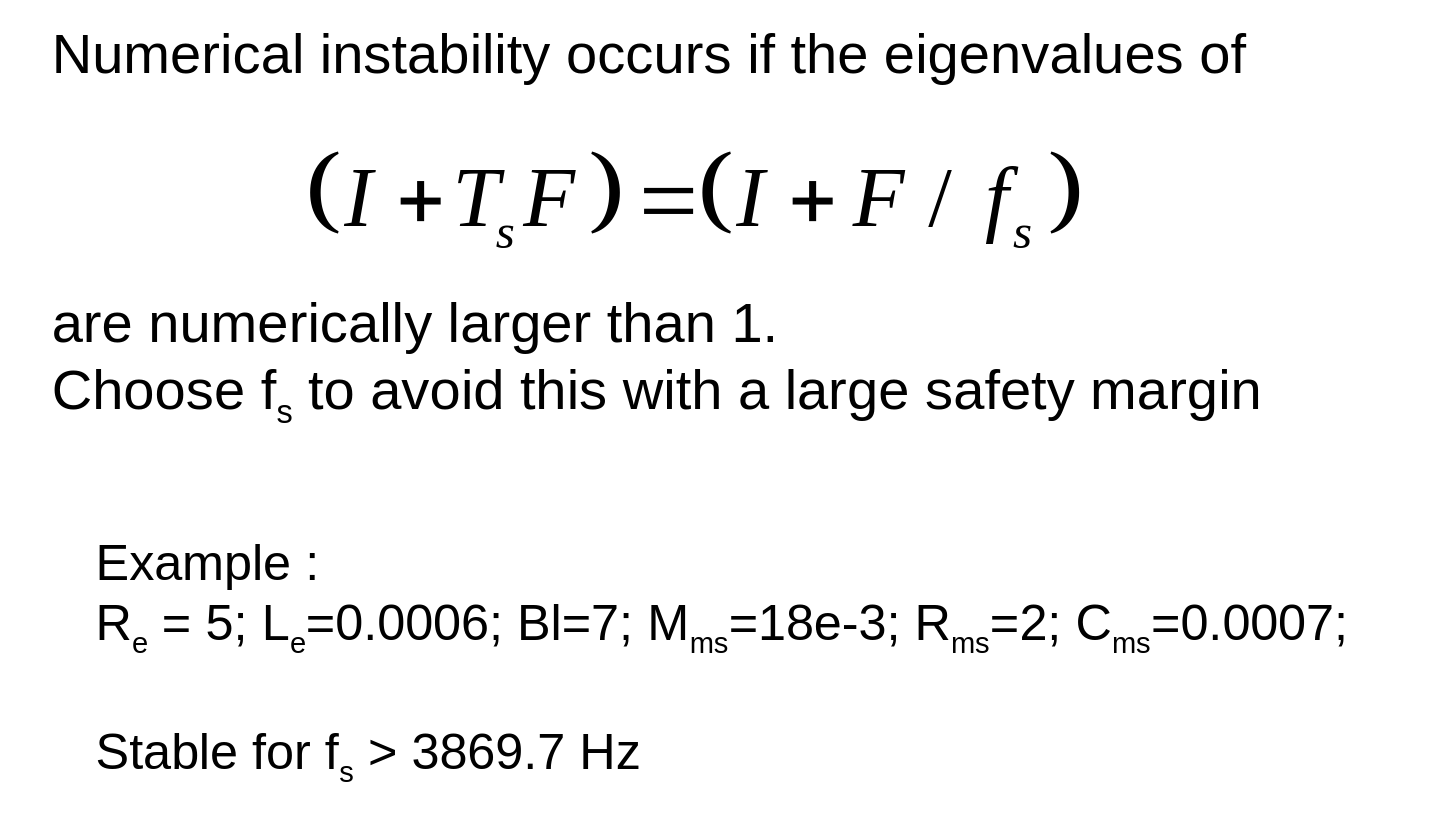